In [89]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import requests
import folium
import urllib
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

### Check new df

In [4]:
velos_paris = pd.read_csv("data/velos_paris.csv", index_col=0)

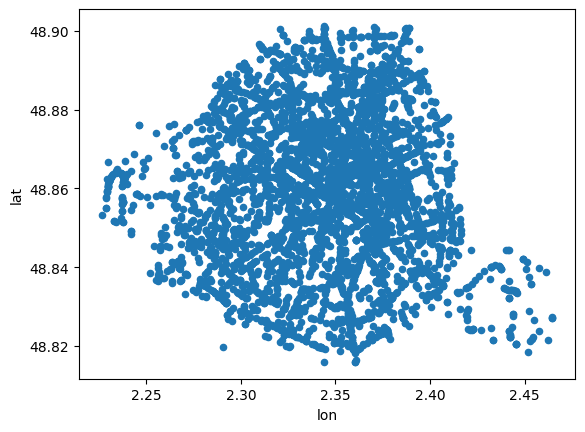

In [6]:
velos_paris_piste = velos_paris[velos_paris.lat > 48.75].plot.scatter("lon", "lat")

In [35]:
velos_paris.head()

,date,mois,jour,heure,departement,commune,lat,lon,en agglomeration,type intersection,...,usage securite,obstacle fixe heurte,obstacle mobile heurte,localisation choc,manoeuvre avant accident,identifiant vehicule,type autres vehicules,manoeuvre autres vehicules,nombre autres vehicules,id_piste
201000062968,2010-10-03,10,6 - dimanche,18.0,75,75112,48.83464,2.43893,oui,Hors intersection,...,Non déterminable,NaN,NaN,Arrière droit,Dépassant à gauche,201000062968A01,Bicyclette,Sans changement de direction,1.0,"48.83440550860086,2.440954977425985"
201000062968,2010-10-03,10,6 - dimanche,18.0,75,75112,48.83464,2.43893,oui,Hors intersection,...,Oui,NaN,NaN,Avant gauche,Sans changement de direction,201000062968B01,Bicyclette,Dépassant à gauche,1.0,"48.83440550860086,2.440954977425985"
201500050797,2015-06-23,6,1 - mardi,18.0,75,75103,48.52011,2.21485,oui,Hors intersection,...,Non déterminable,NaN,Piéton,Avant,Entre 2 files,201500050797A01,NaN,NaN,NaN,NaN
201500052215,2015-08-13,8,3 - jeudi,20.0,75,75110,48.52501,2.21432,oui,Intersection à plus de 4 branches,...,Non déterminable,NaN,Véhicule,NaN,Sans changement de direction,201500052215A01,Motocyclette > 50 cm3 et <= 125 cm3,Sans changement de direction,1.0,NaN
201500055885,2015-06-27,6,5 - samedi,14.0,75,75118,48.53181,2.21070,oui,Intersection en X,...,Oui,NaN,NaN,Côté droit,Dépassant a droite,201500055885B01,VL seul,Ouverture de porte,1.0,NaN


### Api location

In [9]:
def get_location(address: str):
    if not address:
        return None
    url = f'https://nominatim.openstreetmap.org/search/{urllib.parse.quote(address)}?format=json'
    response = requests.get(url).json()
    return response[0]["lat"], response[0]["lon"]

### Api Itineraire

In [10]:
API_URL = "https://wxs.ign.fr/calcul/geoportail/itineraire/rest/1.0.0/route?"

In [17]:
def stringify_loc(location):
    return f"{location[0]},{location[1]}"

In [ ]:
API_URL = "https://wxs.ign.fr/calcul/geoportail/itineraire/rest/1.0.0/route?"

PROFILE = "pedestrian" # or "car"
RESOURCE = "bdtopo-osrm" # more precise, less options than "bdtopo-pgr"
OPTI = "shortest" # or "fastest"
start = 2.3017215728759766, 48.81876120037664
end = 2.324380874633789, 48.8287067867079


query = {
    "start": stringify_loc(start),
    "end": stringify_loc(end),
    "resource": RESOURCE, 
    "profile": PROFILE,
    "optimization": OPTI
}
response_dict = requests.get(API_URL, params=query).json()
response_dict

### API usage

In [34]:
API_URL = "https://wxs.ign.fr/calcul/geoportail/itineraire/rest/1.0.0/route?"

PROFILE = "pedestrian" # or "car"
RESOURCE = "bdtopo-osrm" # more precise, less options than "bdtopo-pgr"
OPTI = "shortest" # or "fastest"
start = 2.3017215728759766, 48.81876120037664 # example
end = 2.324380874633789, 48.8287067867079 # example

def get_path_from_addresses(start, end, profile: str = PROFILE, resource: str = RESOURCE, opti: str = OPTI):
    if isinstance(start, str) & isinstance(end, str):
        start = get_location(start)
        end = get_location(end)
    
    start = start[1], start[0]
    end = end[1], end[0]
    
    query = {
        "start": stringify_loc(start),
        "end": stringify_loc(end),
        "resource": resource, 
        "profile": profile,
        "optimization": opti
    }
    response_dict = requests.get(API_URL, params=query).json()
    path = [(y, x) for x, y in response_dict["geometry"]["coordinates"]]
    true_length = response_dict["distance"]
    return path, true_length

In [257]:
# show path
PARIS_LAT_LONG = [48.864716, 2.349014]
ZOOM_START = 13

import folium

START = "Le Bon Marché, Paris"
END = "Châtelet les Halles, Paris"

start_map = get_location(START)
end_map = get_location(END)
line = get_path_from_addresses(START, END)

map_paris = folium.Map(location=PARIS_LAT_LONG, zoom_start=ZOOM_START)
folium.PolyLine(line, color="red", weight=2.5, opacity=1).add_to(map_paris)
folium.Marker(start_map).add_to(map_paris)
folium.Marker(end_map).add_to(map_paris)
map_paris

### Calculate distances

In [39]:
import math

def dot(v,w):
    x,y = v
    X,Y = w
    return x*X + y*Y

def length(v):
    x,y = v
    return math.sqrt(x*x + y*y)

def vector(b,e):
    x,y = b
    X,Y = e
    return (X-x, Y-y)

def unit(v):
    x,y = v
    mag = length(v)
    return (x/mag, y/mag)

def distance(p0,p1):
    return length(vector(p0,p1))

def scale(v,sc):
    x,y = v
    return (x * sc, y * sc)

def add(v,w):
    x,y = v
    X,Y = w
    return (x+X, y+Y)

def pnt2line(pnt, start, end):
    """
    Calcule la distance entre un points et un segment
    -> renvoie la distance min et le point le plus proche du segment
    """
    line_vec = vector(start, end)
    pnt_vec = vector(start, pnt)
    line_len = length(line_vec)
    line_unitvec = unit(line_vec)
    pnt_vec_scaled = scale(pnt_vec, 1.0/line_len)
    t = dot(line_unitvec, pnt_vec_scaled)    
    if t < 0.0:
        t = 0.0
    elif t > 1.0:
        t = 1.0
    nearest = scale(line_vec, t)
    dist = distance(nearest, pnt_vec)
    nearest = add(nearest, start)
    return (dist, nearest)

In [41]:
import math

def distance_in_meters_between_2_points(x, y):
    # points : lat, lon
    R = 6371e3 # metres
    phi1 = x[0] * math.pi/180 # φ, λ in radians
    phi2 = y[0] * math.pi/180
    D_phi = (y[0]-x[0]) * math.pi/180
    D_lambda = (y[1]-x[1]) * math.pi/180

    a = math.sin(D_phi/2) * math.sin(D_phi/2) + math.cos(phi1) * math.cos(phi2) * math.sin(D_lambda/2) * math.sin(D_lambda/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

    d = R * c # in metres
    return d

In [37]:
def calculate_distance_from_path(point: tuple, polyline: list):
    dist_by_segment = [
        pnt2line(point, polyline[i], polyline[i+1]) 
        for i in range(len(polyline)-1) 
        if polyline[i] != polyline[i+1]
    ]
    minimal_dist, nearest_point = min(dist_by_segment, key=lambda x: x[0], default=(0, 0))
    return nearest_point, distance_in_meters_between_2_points(point, nearest_point)

### Explanatation of calculation of near accidents

In [119]:
# show path
import folium

PARIS_LAT_LONG = [48.864716, 2.349014]
ZOOM_START = 13


def show_accident_and_line(accident_point, polyline, start, end, nearest):
    map_paris = folium.Map(location=PARIS_LAT_LONG, zoom_start=ZOOM_START)
    folium.PolyLine(polyline, color="red", weight=2.5, opacity=1).add_to(map_paris)
    folium.Marker(start, popup="start").add_to(map_paris)
    folium.Marker(end, popup="end").add_to(map_paris)
    folium.Marker(accident_point, popup="accident")
    folium.PolyLine([accident_point, nearest], color="blue", weight=2.5, opacity=1).add_to(map_paris)
    return map_paris

In [44]:
START = "Le Bon Marché, Paris"
END = "Châtelet les Halles, Paris"

start_map = get_location(START)
end_map = get_location(END)
line, true_length = get_path_from_addresses(START, END)

accident = velos_paris.iloc[-2]
accident = accident.lat, accident.lon

nearest, dist = calculate_distance_from_path(accident, line)

print(f"Distance en mètres : {distance_in_meters_between_2_points(accident, nearest)}")

show_accident_and_line(accident, line, start_map, end_map, nearest)

Distance en mètres : 913.594138959016


### Functions to get all close accidents from a line

In [46]:
def get_close_accidents(polyline, df_accidents):
    df_results = df_accidents[["lat", "lon", "gravite accident", "date"]]
    for idx, row in df_results.iterrows():
        accident_loc = row.lat, row.lon
        nearest, dist = calculate_distance_from_path(accident_loc, polyline)
        df_results.loc[idx, "distance_in_m"] = distance_in_meters_between_2_points(accident_loc, nearest)
        
    return df_results

In [66]:
def show_near_accidents(polyline, start, end, df_distances):
    map_paris = folium.Map(location=PARIS_LAT_LONG, zoom_start=ZOOM_START)
    folium.PolyLine(polyline, color="red", weight=2.5, opacity=1).add_to(map_paris)
    folium.Marker(start, popup="start").add_to(map_paris)
    folium.Marker(end, popup="end").add_to(map_paris)
    for _, row in df_distances.iterrows():
        accident_point = row.lat, row.lon
        folium.Marker(accident_point, popup=f"Accident à une distance de {round(row.distance_in_m, 2)} mètres le {row.date}.\n {row['gravite accident']}").add_to(map_paris)
    return map_paris

### Sum up

In [48]:
START = "Champ de Mars, Paris"
END = "Gare de Lyon, Paris"

start_map = get_location(START)
end_map = get_location(END)
line, true_length = get_path_from_addresses(START, END)

distances = get_close_accidents(line, velos_paris)
near_accidents = distances[distances["distance_in_m"] < 50]
show_near_accidents(line, start, end, near_accidents)

/var/folders/19/pckvwjyn0r7630jpjn3lh1800000gn/T/ipykernel_18991/151037087.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results.loc[idx, "distance_in_m"] = distance_in_meters_between_2_points(accident_loc, nearest)


In [51]:
accidents_per_km = (len(near_accidents) / true_length)*1000
f"Il y a {round(accidents_per_km, 2)} accidents par km sur cet itinéraire"

'Il y a 16.57 accidents par km sur cet itinéraire'

### Croisement avec les compteurs

In [56]:
counter_infos = pd.read_csv("data/counter_infos.csv", index_col=0)

In [63]:
counter_infos.head()

,name,coordinates,counter,number,street,start_address,start_loc,end_address,end_loc
0,10 avenue de la Grande Armée,"48.8748,2.2924",Y2H18034808,10.0,avenue de la Grande Armée,"1 avenue de la Grande Armée, Paris","48.8740552,2.2930687","60 avenue de la Grande Armée, Paris","48.8768331,2.2865341"
1,10 boulevard Auguste Blanqui,"48.83082,2.35317",Y2H18086319,10.0,boulevard Auguste Blanqui,"1 boulevard Auguste Blanqui, Paris","48.8307103,2.3543931","60 boulevard Auguste Blanqui, Paris","48.8300869,2.3486916"
3,102 boulevard de Magenta,"48.87769,2.35475",Y2H18086312,102.0,boulevard de Magenta,"1 boulevard de Magenta, Paris","48.8687802,2.3624897","152 boulevard de Magenta, Paris","48.8819247,2.3512393"
4,105 rue La Fayette,"48.87773,2.3506",Y2H21100756,105.0,rue La Fayette,"1 rue La Fayette, Paris","48.8732688,2.3335955","155 rue La Fayette, Paris","48.8744015,2.3383062"
5,106 avenue Denfert Rochereau,"48.83505,2.33333",Y2H16029278,106.0,avenue Denfert Rochereau,"1 avenue Denfert Rochereau, Paris","48.8360677,2.334032","156 avenue Denfert Rochereau, Paris","48.8360677,2.334032"


In [61]:
def floatify(str_coord):
    x, y = str_coord.split(",")
    return float(x), float(y)

In [87]:
row = counter_infos.iloc[9]
start = floatify(row.start_loc)
end = floatify(row.end_loc)

line, true_length = get_path_from_addresses(start, end)

distances = get_close_accidents(line, velos_paris)
near_accidents = distances[distances["distance_in_m"] < 50]
map_itineraire_with_accidents = show_near_accidents(line, start, end, near_accidents)

accidents_per_km_per_year = (len(near_accidents) / true_length)*1000 / (2021-2010)

print(f"Compteur de {row['name']}")
print(f"Il y a eu {round(accidents_per_km_per_year, 2)} accidents par km par an sur la route où est placée ce compteur")
map_itineraire_with_accidents

Compteur de 152 boulevard du Montparnasse
Il y a eu 3.43 accidents par km par an sur la route où est placée ce compteur


In [101]:
for idx, row in tqdm(counter_infos.iterrows(), total=len(counter_infos)):
    try:
        start = floatify(row.start_loc)
        end = floatify(row.end_loc)

        line, true_length = get_path_from_addresses(start, end)

        distances = get_close_accidents(line, velos_paris)
        near_accidents = distances[distances["distance_in_m"] < 50]
        map_itineraire_with_accidents = show_near_accidents(line, start, end, near_accidents)

        accidents_per_km_per_year = (len(near_accidents) / true_length)*1000 / (2021-2010)
        counter_infos.loc[idx, "accident_per_km_per_year"] = accidents_per_km_per_year
    except Exception as e:
        continue

100%|███████████████████████████████████████████| 52/52 [01:13<00:00,  1.42s/it]


In [120]:
near_accidents

,lat,lon,gravite accident,date,distance_in_m
201600054088,48.843200,2.366150,1 - Blessé léger,2016-11-27,33.516515
201700055069,48.840700,2.369580,1 - Blessé léger,2017-03-11,5.840780
201700055197,48.840100,2.370720,0 - Indemne,2017-06-30,24.760611
201700055197,48.840100,2.370720,1 - Blessé léger,2017-06-30,24.760611
201700055215,48.838000,2.373250,1 - Blessé léger,2017-07-16,13.019057
201800052326,48.838700,2.372340,1 - Blessé léger,2018-02-01,6.510076
201800052341,48.837600,2.373640,1 - Blessé léger,2018-02-19,20.912251
201900006177,48.843140,2.366221,Blessé léger,2019-02-08,25.134833
201900011983,48.838332,2.372799,Blessé léger,2019-10-16,5.730157
201900018521,48.838330,2.372799,Blessé léger,2019-03-14,5.601758
